In [56]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_mldata, load_digits
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

plt.gray()
%matplotlib inline

In [73]:
mnist = fetch_mldata('MNIST original')
X = mnist['data']
y = mnist['target']

# X, y = load_digits(return_X_y=True)

In [87]:
ex_ix = np.array([np.argmax(y==i) for i in range(10)])

In [93]:
pca = PCA(n_components=10)
a = pca.fit_transform(X)

In [75]:
avg_decomps = np.zeros((10, a.shape[1]))
for i in range(10):
    avg_decomps[i] = a[y==i].mean(0)

In [76]:
gmm = GaussianMixture(n_components=10, n_init=1, verbose=1)
gmm.fit(a)

Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=10, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=1,
        verbose_interval=10, warm_start=False, weights_init=None)

In [77]:
km = KMeans(n_clusters=10, n_init=1)
km.fit(a)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

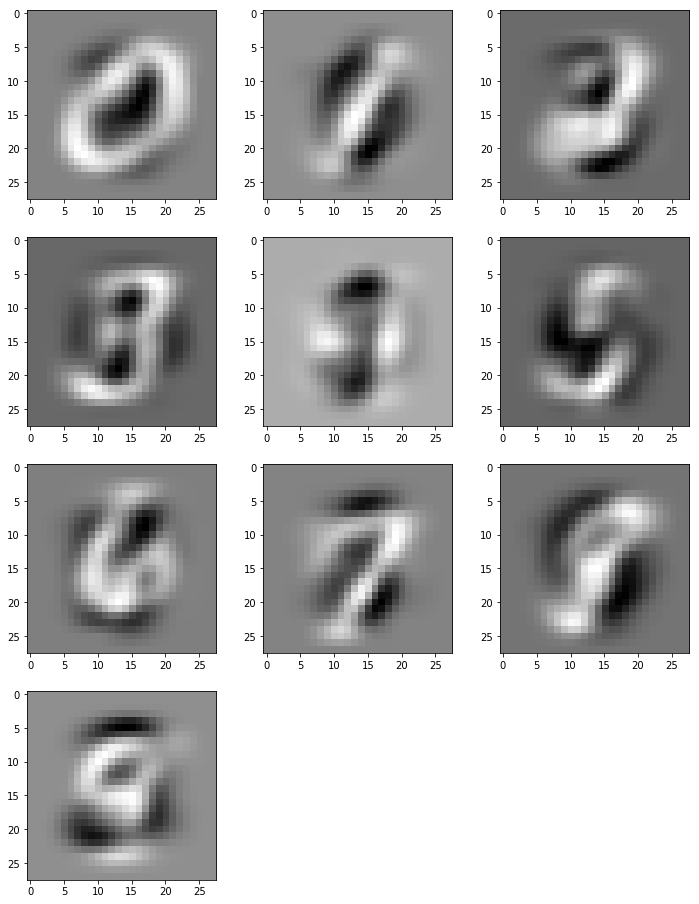

In [94]:
# recon = gmm.means_.dot(pca.components_)
# recon = km.cluster_centers_.dot(pca.components_)
# recon = avg_decomps.dot(pca.components_)
recon = pca.components_.T.dot(a[ex_ix].T).T
recon += recon.min()
plt.figure(figsize=(12, 16))
for i in range(10):
    ax = plt.subplot(4, 3, i+1)
    ax.imshow(recon[i].reshape(int(np.sqrt(X.shape[1])), -1))

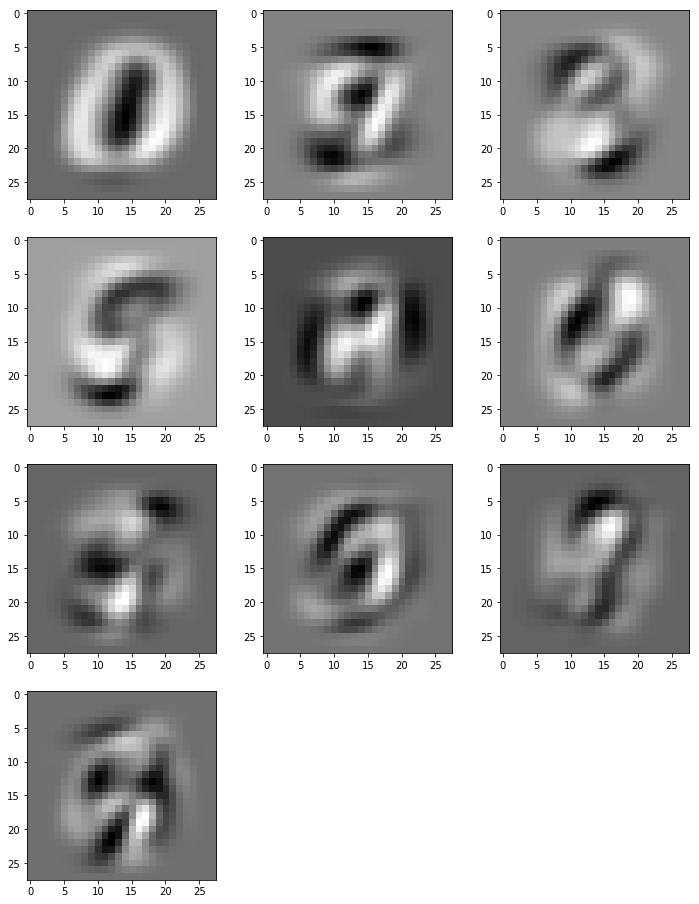

In [79]:
plt.figure(figsize=(12, 16))
for i in range(10):
    ax = plt.subplot(4, 3, i+1)
    ax.imshow(pca.components_[i].reshape(int(np.sqrt(X.shape[1])), -1))